ChEn-3170: Computational Methods in Chemical Engineering Spring 2024 UMass Lowell; Prof. V. F. de Almeida **25Mar24**

# 10. Shortest Least-Squares Solver
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\yvec}{\boldsymbol{\mathsf{y}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
  * [Introduction](#intro)
  * [Detailed Algorithm w/ Wrapper Solve Function](#algo)
  * [Test](#test)
    + [Data](#data)
    + [Compute](#compute)
  * [Another Test](#another)
    + [Data](#anotherdata)
    + [Compute](#anothercompute)
---

## [Introduction](#toc)<a id="intro"></a>

Recall course notes OneNote [ChEn-3170-shortest-lsq-solver](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EqrHIQZxGsdKnllQsn2RmvMBlIFaz2TtXan8aldgK6WWuw?e=Z7EnCh) on computational stoichiometry including an introduction to the linear, rank-deficient, least-squares method.

Compute the solution vector $\xvec$ for a given matrix $\Amtrx$ and right-side vector $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

When $\Amtrx$ is rank deficient, $\Amtrx^\top\Amtrx$ is also rank deficient (or singular). The normal equations 

\begin{equation*}
\boxed{\Amtrx^\top\Amtrx\,\xvec_\text{LS}  = \Amtrx^\top\,\bvec },
\end{equation*}

*either have an infinite number of solutions or have no solution*. 

Since $\Amtrx$ is rank deficient, a **unique** mininum-norm least squares solution, $\xvec_\text{MNLS}$, exists as follows,

\begin{equation*}
\min\limits_\xvec \Bigl( \norm{\bvec - \Amtrx\,\xvec_\text{MNLS}}^2 +  \lim\limits_{\epsilon\rightarrow 0}\,\epsilon\,\norm{\xvec_\text{MNLS}}^2 \Bigr) \quad\  \forall \quad\ \xvec.
\end{equation*}

This solution is obtained by solving:

\begin{equation*}
\boxed{
\lim\limits_{\epsilon\rightarrow 0}\,\bigl(\Amtrx^\top\Amtrx + \epsilon\Imtrx\bigr) \xvec_\text{MNLS}  = \Amtrx^\top\,\bvec },
\end{equation*}

where $\Amtrx^\top\Amtrx + \epsilon\Imtrx$ is square, symmetric and full rank. This augmented least-squares problem has a unique solution.

## [Detailed Algorithm w/ Wrapper Solve Function](#toc)<a id="algo"></a>
Refer to course Notebooks [08](https://nbviewer.org/github/dpploy/chen-3170/blob/master/notebooks/08-full-rank-least-squares-reaction-rate.ipynb) and [09](https://nbviewer.org/github/dpploy/chen-3170/blob/master/notebooks/09-rank-deficient-least-squares-reaction-rate.ipynb).

In [1]:
'''Wrapper Shortest LS Solve Function'''

import numpy as np

try:    
    from chen_3170.toolkit import solve   
    from chen_3170.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own solve function here. Bailing out.'
    
def shortest_least_squares_solve(a_mtrx, b_vec, epsilon_min=-8, 
                                 pivoting_option='partial', pivot_tol=1e-8, zero_tol=None, verbose=False):
    if verbose:
        np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
        
    epsilon_values = np.logspace(+2,epsilon_min,12)
    
    if matrix_rank(a_mtrx) < min(a_mtrx.shape):
        pivot_tol = epsilon_values[-1]
    
    x_norm_history = list() # return to caller
    phi_tilde_history = list() # return to caller

    for epsilon in epsilon_values:

        if verbose:
            print('')
            print('epsilon = %1.1e'%epsilon)
            print('')

        mtrx = a_mtrx.transpose() @ a_mtrx + epsilon * np.eye(a_mtrx.shape[1]) # AT A + epsilon I, AT A is the normal matrix
        vec  = a_mtrx.transpose() @ b_vec                            # AT b

        # Solve (ATA + epsilon I) x = AT b
        x_vec = solve(mtrx, vec, pivoting_option=pivoting_option, pivot_tol=pivot_tol, zero_tol=zero_tol) # matrix is full rank
        #x_vec = np.linalg.solve(mtrx, vec) # if my solver does not work
        
        x_norm = np.linalg.norm(x_vec)
        if verbose:
            print('||x|| = %8.5e'%x_norm)
    
        x_norm_history.append(x_norm) # save for plotting
    
        # test my solution against NumPy solve
        if verbose:
            print('max(abs(x_vec-x_vec_numpy)) = %2.2e'%np.max(np.abs((x_vec - np.linalg.solve(mtrx, vec)))))
    
        if verbose:
            print('')
        
        residual_vec = b_vec - a_mtrx @ x_vec
        phi_tilde_history.append(np.linalg.norm(residual_vec)**2 + epsilon*x_norm**2)

        if verbose:
            print('||b - A x||^2 + eps*||x||^2 = %8.5e'%phi_tilde_history[-1])
            print('||(ATA-epsI)x - ATb||       = %8.5e'%(np.linalg.norm(mtrx@x_vec-a_mtrx.transpose()@b_vec)))
            print('||b - A x|| +       ||x||   = %8.5e'%(np.linalg.norm(residual_vec) + x_norm))
            print('||b - A x||                 = %8.5e'%(np.linalg.norm(residual_vec)))   

    return (x_vec, (epsilon_values, x_norm_history, phi_tilde_history))

## [Test](#toc)<a id="test"></a>

### [Data](#toc)<a id="data"></a>

In [2]:
'''Any A matrix'''

import numpy as np

nrows = 20
ncols = 32

a = -12.2
b =  88.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a
a_mtrx /= a_mtrx.max()

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-8:] = 0.0
    if nrows < ncols:
        a_mtrx[-8:,:] = 0.0
        
np.set_printoptions(precision=3, threshold=500, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 0.022  0.555  0.455  0.263 ... -0.127  0.074  0.904  0.415]
 [ 0.589  0.762  0.883  0.488 ... -0.094  0.633  0.857  1.   ]
 [ 0.238  0.092  0.796  0.995 ... -0.115  0.92   0.28   0.766]
 [ 0.999  0.75   0.592 -0.036 ...  0.756  0.976 -0.13   0.119]
 ...
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]]


In [4]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
#a_rank = np.linalg.matrix_rank(a_mtrx) # use this if your matrix_rank is broken
print('A shape   = ',a_mtrx.shape)
print('Rank of A = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

A shape   =  (20, 32)
Rank of A =  12
Matrix is rank deficient.


In [5]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [-31.675 -32.777 -20.722 -35.135 -25.125 -39.661 -31.038  -5.145   1.335 -28.565  -2.997 -27.38
  -2.339 -30.136 -22.377 -27.71  -24.33  -29.631 -16.314 -26.428]


### [Compute](#toc)<a id="compute"></a>

In [8]:
'''Compute the MNLS solution'''

# use verbose = True for printout
(x_vec, history) = shortest_least_squares_solve(a_mtrx, b_vec, verbose=False, zero_tol=1e-12)

In [9]:
'''Plot Convergence Function'''

def plot_convergence(history):
    (epsilon_hist, x_norm_hist, phi_tilde_hist) = history
    from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
    #%matplotlib inline
    #plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(figsize=(13,4))
    ax1.semilogx(epsilon_hist, x_norm_hist,'ro--')
    ax1.set_ylabel('MNLS Solution Norm',fontsize=16)
    ax1.set_xlabel('Epsilon',fontsize=16)
    ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    fig.suptitle('Convergence of Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
    ax1.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)

    ax2 = ax1.twinx()

    ax2.semilogx(epsilon_hist, phi_tilde_hist,'go-')
    ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax2.set_ylabel('Objective Function $\\tilde{\phi}_\epsilon(r)$', fontsize=16)
    plt.show()

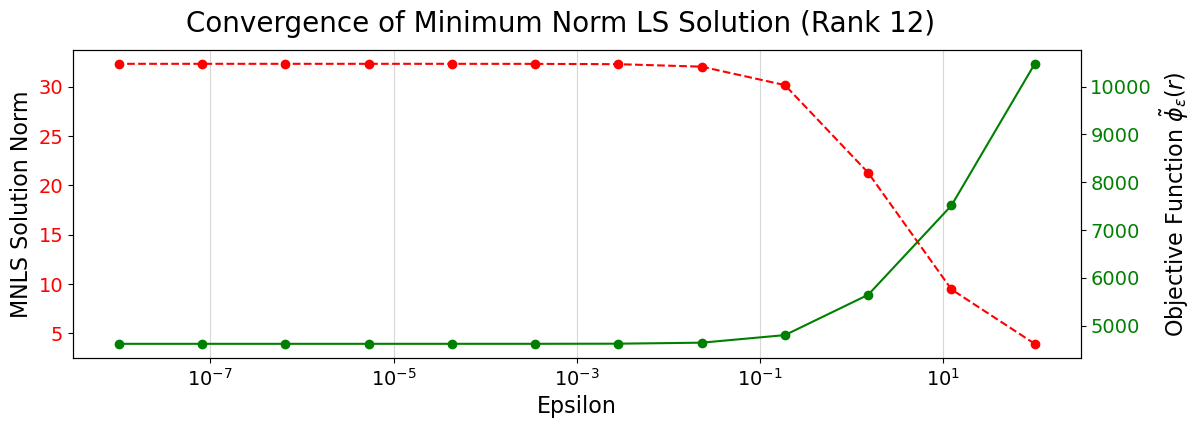

In [10]:
'''Plot Convergence of the Shortest Least-Square Solution Vector'''

plot_convergence(history)

**NB:** Note that from the previous results, the associated rank-deficient $\Amtrx\xvec=\bvec$ has no solution. The computed $\xvec$ is the shortest LS solution of the modified (*regularized*) LS problem.

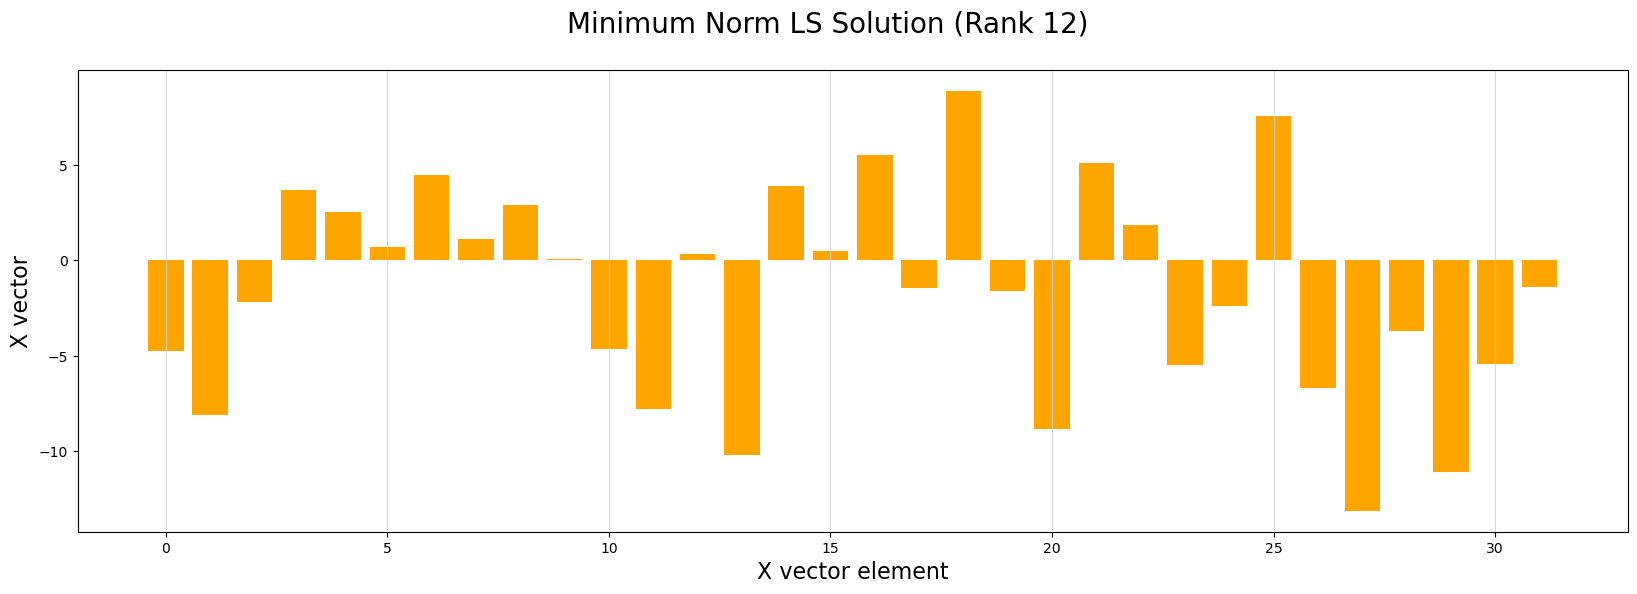

In [11]:
'''Minimum-norm least-squares solution'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
plt.show()

## [Another Test](#toc)<a id="another"></a>

Compute the solution vector $\xvec$, given $\Amtrx$ and $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

### [Data](#toc)<a id="anotherdata"></a>

In [12]:
'''Any A matrix'''

import numpy as np

nrows = 54
ncols = 28

a = -120.2
b =  808.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a
a_mtrx /= a_mtrx.max()

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-1] = 0.0
    if nrows < ncols:
        a_mtrx[-1,:] = 0.0
        
np.set_printoptions(precision=3, threshold=100, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 0.647  0.2    0.097 -0.045 ...  0.041  0.037  0.752  0.   ]
 [ 0.403  0.463  0.524  0.218 ...  0.222  0.624  0.455  0.   ]
 [ 0.158  0.11   0.13   0.523 ...  0.741  0.989  0.416  0.   ]
 [ 0.64   0.224  0.538  0.606 ...  0.483  0.701  0.88   0.   ]
 ...
 [ 0.124  0.277  0.853  0.087 ...  0.632  0.173 -0.052  0.   ]
 [ 0.558  0.589  0.365  0.062 ...  0.565  0.669  0.05   0.   ]
 [ 0.443 -0.022  0.413  0.599 ...  0.955  0.269  0.591  0.   ]
 [-0.049  0.681  0.98   0.536 ...  0.674  0.55   0.885  0.   ]]


In [13]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (54, 28)
Rank of S =  27
Matrix is rank deficient.


In [14]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [-21.328 -15.421 -20.048 -14.042 -11.63  -32.91   -4.871   2.26  -37.717 -20.146  -6.331  -8.559
 -17.965 -11.819 -28.545 -37.923 -38.957 -26.143 -28.018  -1.384 -37.767 -11.433  -7.902 -36.919
 -15.843 -25.993 -34.999   3.053 -30.57  -16.094 -17.868 -32.402 -27.176 -16.837  -4.412 -34.339
 -23.268 -16.054  -9.833 -22.859 -35.458  -5.458 -15.813 -19.485  -3.956 -28.688 -34.352 -22.679
 -39.88  -40.146 -22.313   2.823 -22.616  -5.148]


### [Compute](#toc)<a id="anothercompute"></a>

In [15]:
# reusing the wrapper solve function
(x_vec, history) = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-12)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of solution vector: ||x|| = %3.3e'%np.linalg.norm(x_vec))

Magnitude of residual vector: ||b - Ax|| = 4.719e+01
Magnitude of solution vector: ||x|| = 6.844e+01


In [16]:
# using an external solve function
try:    
    from chen_3170.toolkit import shortest_least_squares_solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

x_vec = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-10)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of solution vector: ||x|| = %3.3e'%np.linalg.norm(x_vec))

Magnitude of residual vector: ||b - Ax|| = 4.719e+01
Magnitude of solution vector: ||x|| = 6.844e+01


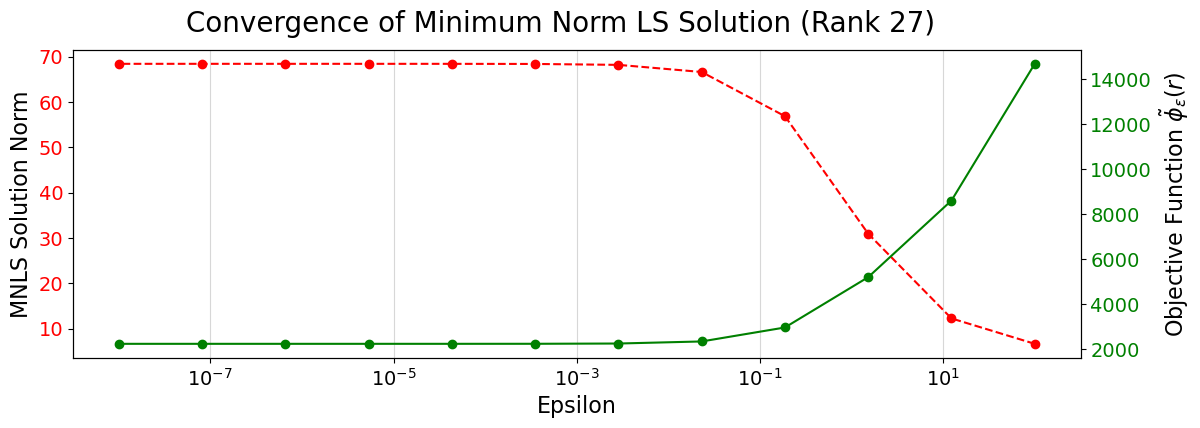

In [17]:
plot_convergence(history)

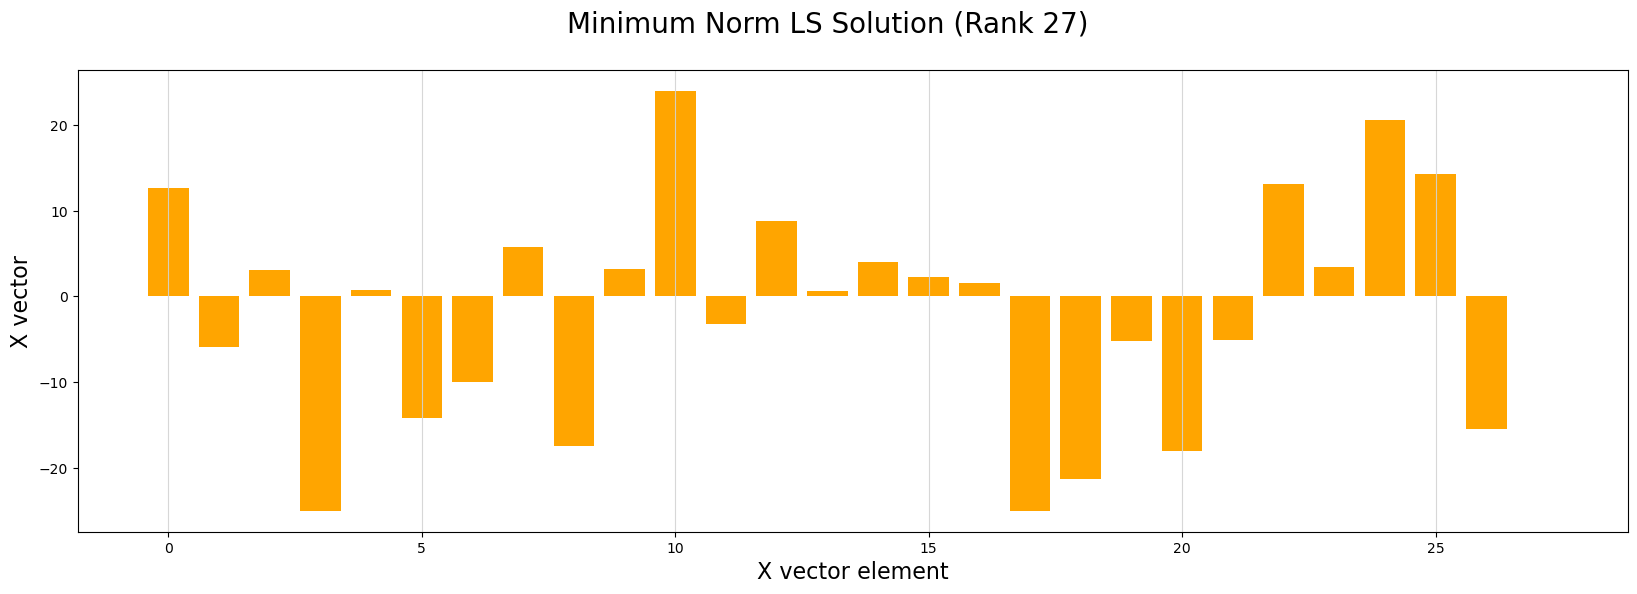

In [18]:
'''Minimum norm least-squares solution'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
plt.show()